# Setting up and reading data files

In [14]:
import numpy as np
import pandas as pd
from uniqify import uniqify
from unlistify import unlistify
import pickle

In [15]:
#-------------------------------------------------------------------------
# Loading all relevant data files. 
# NOTE: please unzip the file: kegg_files.zip and make sure all the 
# following files can be read by the program in order for the analysis
# to work.
#-------------------------------------------------------------------------
stoich_matrix = np.load('akshit_stoich_matrix.npy')
names = [e[:-1] for e in open('akshit_names.txt', 'r').readlines()]
rxns = ''.join(open('akshit_rxns.txt', 'r').readlines()).split()
cpds = ''.join(open('akshit_mets.txt', 'r').readlines()).split()

met_map = kegg_to_id = {cpds[e] : e for e in range(len(cpds))}
inv_met_map = id_to_kegg = {value: key for key, value in met_map.items()}
rxn_map = rxn_kegg_to_id = {rxns[e] : e for e in range(len(rxns))}
inv_rxn_map = rxn_id_to_kegg = {value: key for key, value in rxn_map.items()}
cpd_string_dict = {cpds[e] : names[e] for e in range(len(names))}

#-------------------------------------------------------------------------
# Parsing some KEGG reactions correctly.
#-------------------------------------------------------------------------
stoich_matrix[rxn_kegg_to_id['R11307']][kegg_to_id['C00760']] = -1
stoich_matrix[rxn_kegg_to_id['R00803']][kegg_to_id['C00103']] = 0
stoich_matrix[rxn_kegg_to_id['R00028']][kegg_to_id['C00031']] = 0
stoich_matrix[rxn_kegg_to_id['R00028']][kegg_to_id['C00267']] = 1
stoich_matrix[rxn_kegg_to_id['R00010']][kegg_to_id['C00031']] = 0
stoich_matrix[rxn_kegg_to_id['R00010']][kegg_to_id['C00267']] = 1
stoich_matrix[rxn_kegg_to_id['R00839']][kegg_to_id['C00031']] = 0

#-------------------------------------------------------------------------
# Initializing and setting the currency molecules.
#-------------------------------------------------------------------------
Currency = ''.join(open('ncurr.txt', 'r').readlines()).split()

#-------------------------------------------------------------------------
# Defining reactant, product and reactant number vectors for the scope 
# expansion algorithm.
#-------------------------------------------------------------------------
rxnMat = ((stoich_matrix.clip(max = 0.0)) != 0) * 1
prodMat = (stoich_matrix.clip(min = 0.0) != 0) * 1
sumRxnVec = np.sum(rxnMat, axis = 1)
sumProdVec = np.sum(prodMat, axis = 1)

 Defining all 16 carbon sources used in the experiment.

In [16]:
martina_cpd_to_kegg = dict( pd.read_csv( 'compound_to_kegg.csv' ).values.tolist( ) )
martina_cpd_to_kegg[ 'glucose' ] = 'C00221'
martina_cpd_to_kegg[ 'cellobiose' ] = 'C04534'
martina_cpd_to_kegg

{'maltose': 'C00208',
 'fumarate': 'C00122',
 'galacturonate': 'C00333',
 'sucrose': 'C00089',
 'sorbitol': 'C00794',
 'cellulose': 'C00760',
 'cellobiose': 'C04534',
 'fructose': 'C00095',
 'citrate': 'C00158',
 'mannose': 'C00159',
 'xylose': 'C00181',
 'mannitol': 'C00392',
 'glycerol': 'C00116',
 'starch': 'C00369',
 'proline': 'C01157',
 'glucose': 'C00221'}

### Reading media 

In [17]:
martina_media_df = pd.read_excel( 'media_from_martina_modified_names.xlsx', index_col=0 ).fillna( '' )
media_listoflist = list( martina_media_df.values.tolist( ) )
for idx, tm in enumerate( media_listoflist ):
    media_listoflist[ idx ] = list( filter( None, tm ) )
kegg_media = [ [ martina_cpd_to_kegg[ e ] for e in tm ] for tm in media_listoflist ]

In [18]:
CS = [id_to_kegg[kegg_to_id[e]] for e in uniqify( unlistify( kegg_media ) )]

Checking that we have 75 defined media in total.

In [19]:
len(kegg_media)

75

# The scope expansion algorithm

In [20]:
def giveScope(rxnMat, prodMat, seedVec, sumVec):
    """
    Takes in the stoichiometric matrix in the form of a reaction 
    and product matrix, along with a sum vector mentioning the 
    number of reactants in each reaction in the matrix. Also takes
    in a vector of initially seeded metabolites (in seedVec).

    Expands, beginning from the seeded metabolites, a set of reactions
    and metabolites that can be reached iteratively from the former.
    

    RETURNS:
    Returns a set of 'scope-expanded' metabolites and reactions in the 
    stoichiometric matrix form.

    currScopeMets is the set of metabolites, with their usual IDs.
    rxnProc is the set of reactions with my personal IDs 
    """
    currScopeMets = np.copy(seedVec)
    scopeSize = sum(currScopeMets)
    prevScopeSize = 0.0

    while scopeSize > prevScopeSize:
        prevScopeSize = scopeSize

        # This generates the rho vector.
        rxnProc = ((np.dot(rxnMat, currScopeMets) - sumVec) == 0) * 1
        # This generates the phi vector.
        currScopeMets = (np.dot(np.transpose(prodMat), rxnProc) + currScopeMets > 0) * 1

        # Recalculating scope size.
        scopeSize = sum(currScopeMets)

    return currScopeMets, rxnProc

# Preparing all reaction maps from KEGG to use

### Getting all amino acid reaction maps

In [21]:
aa03 = ''.join(open('aa_maps/map00250.txt', 'r').readlines()).split()
aa04 = ''.join(open('aa_maps/map00260.txt', 'r').readlines()).split()
aa05 = ''.join(open('aa_maps/map00270.txt', 'r').readlines()).split()
aa06 = ''.join(open('aa_maps/map00280.txt', 'r').readlines()).split()
aa07 = ''.join(open('aa_maps/map00290.txt', 'r').readlines()).split()
aa08 = ''.join(open('aa_maps/map00300.txt', 'r').readlines()).split()
aa09 = ''.join(open('aa_maps/map00310.txt', 'r').readlines()).split()
aa10 = ''.join(open('aa_maps/map00330.txt', 'r').readlines()).split()
aa11 = ''.join(open('aa_maps/map00340.txt', 'r').readlines()).split()
aa12 = ''.join(open('aa_maps/map00350.txt', 'r').readlines()).split()
aa13 = ''.join(open('aa_maps/map00360.txt', 'r').readlines()).split()
aa14 = ''.join(open('aa_maps/map00380.txt', 'r').readlines()).split()
canaa = aa03 + aa04 + aa05 + aa06 + aa07 + aa08 + aa09 + aa10 + aa11 + aa12 + aa13 + aa14

### Getting all carbohydrate and carbon metabolism maps

In [22]:
can1 = ''.join(open('rn00330.txt', 'r').readlines()).split()
can2 = ''.join(open('map01200.txt', 'r').readlines()).split()
can3 = ''.join(open('map00051.txt', 'r').readlines()).split()
can4 = ''.join(open('map00500.txt', 'r').readlines()).split()
can5 = ''.join(open('map00040.txt', 'r').readlines()).split()
can6 = ''.join(open('map00561.txt', 'r').readlines()).split()
can = can1 + can2 + can3 + can4 + can5 + can6 + canaa
can = list((set(can)) & set(rxns))

### Removing a manually curated list of reactions which are not specific to soil bacteria.

In [23]:
fwrxns = [rxn_kegg_to_id[e] for e in can if e not in [ 'R03292', 'R03293', 'R11819', 'R04447', 'R04446', 'R03295', 'R03290', 'R03291', 'R02727', 'R00801', 'R05140', 'R11790', 'R04194', 'R00806', 'R02120', 'R01823', 'R00178', 'R11791', 'R11309', 'R00948', 'R00872', 'R09945', 'R04111', 'R01555',  'R01557', 'R01295', 'R11540', 'R00341', 'R00345', 'R00354', 'R00479', 'R00878', 'R09994', 'R02110']]
mp = int(len(stoich_matrix)/2)
rvrxns = [ mp + 295, mp + 286, mp + rxn_kegg_to_id['R01251'], mp + rxn_kegg_to_id['R00352'], mp + rxn_kegg_to_id['R01082'], mp + rxn_kegg_to_id['R01518'], mp + rxn_kegg_to_id['R09477'], mp + rxn_kegg_to_id['R07676'], mp + rxn_kegg_to_id['R01082'], mp + rxn_kegg_to_id['R00658'] ]
avrxns = fwrxns + rvrxns + [286, 189]

avoid_rxns = []
for trxn in avrxns:
    crs = set([kegg_to_id[e] for e in Currency])
    if (set(np.nonzero(rxnMat[trxn])[0]) & crs) == set(np.nonzero(rxnMat[trxn])[0]):
        avoid_rxns.append(trxn)

avoid_rxns = [rxn_id_to_kegg[e] for e in avoid_rxns]

for tind, trow in enumerate(stoich_matrix):
    if trow[kegg_to_id['C00718']] == 1 and tind < mp:
        avoid_rxns.append(rxn_id_to_kegg[tind])

fwrxns = [rxn_kegg_to_id[e] for e in can if e not in avoid_rxns + [ 'R03292', 'R03293', 'R11819', 'R04447', 'R04446', 'R03295', 'R03290', 'R03291', 'R02727', 'R00801', 'R05140', 'R11790', 'R04194', 'R00806', 'R02120', 'R01823', 'R00178', 'R11791', 'R11309', 'R00948', 'R00872', 'R09945', 'R04111', 'R01555',  'R01557', 'R01295', 'R11540', 'R00341', 'R00345', 'R00354', 'R00479', 'R00878', 'R09994', 'R02110']]
mp = int(len(stoich_matrix)/2)
rvrxns = [ mp + 295, mp + 286, mp + rxn_kegg_to_id['R01251'], mp + rxn_kegg_to_id['R00352'], mp + rxn_kegg_to_id['R01082'], mp + rxn_kegg_to_id['R01518'], mp + rxn_kegg_to_id['R09477'], mp + rxn_kegg_to_id['R07676'], mp + rxn_kegg_to_id['R01082'], mp + rxn_kegg_to_id['R00658'] ]
avrxns = fwrxns + rvrxns + [286, 189]
len( avrxns )

1209

# Performing scope expansion

In [24]:
from tqdm import tqdm 
calc_scopes = {}
rxn_scopes = {}
for media_id in tqdm( range( 1, len( kegg_media ) + 1 ) ):
    seedVec = np.zeros(len(rxnMat.T))
    media = kegg_media[ media_id - 1 ]
    seedVec[[kegg_to_id[e] for e in Currency + media]] = 1
    scopeMets, rxnProc = giveScope( rxnMat[ avrxns ], prodMat[ avrxns ], seedVec, sumRxnVec[ avrxns ])
    transrxn = np.zeros(len(stoich_matrix))
    transrxn[avrxns] = np.copy(rxnProc)
    rxnProc = np.copy(transrxn)
    calc_scopes[ media_id ] = scopeMets
    rxn_scopes[ media_id ] = rxnProc[:]

100%|██████████| 75/75 [00:36<00:00,  2.93it/s]


### Calculating the scope of currency molecules. 

In [25]:
seedVec = np.zeros(len(rxnMat.T))
seedVec[[kegg_to_id[e] for e in Currency]] = 1
currScope, currRxn = giveScope( rxnMat[ avrxns ], prodMat[ avrxns ], seedVec, sumRxnVec[ avrxns ])

transrxn = np.zeros(len(stoich_matrix))
transrxn[avrxns] = np.copy(currRxn)
currRxn = np.copy(transrxn)
rxn_curr = set(np.nonzero( currRxn )[0])

currMets = set(np.nonzero( currScope )[0])

# 3 reactions can be performed using only the currency metabolites.
print( len( rxn_curr ) )

3


### Removing the scope of all currency molecules to get final scopes for each medium.

In [26]:
filt_scope = {}
filt_scope_size = {}
for ind in tqdm( range( 1, len( kegg_media ) + 1 ) ):
    rxnProc = np.zeros_like( currRxn )
    rxn_tm = set(np.nonzero( rxn_scopes[ind] )[0])
    rxnProc[ list( rxn_tm - rxn_curr ) ] = 1
    rxnProc[ 189 ] = 1
    seedVec = np.zeros(len(rxnMat.T))
    media = kegg_media[ ind - 1 ]
    seedVec[[kegg_to_id[e] for e in Currency + media]] = 1
    currScopeMets = np.copy( seedVec )
    currScopeMets = (np.dot(np.transpose(prodMat[ avrxns ]), rxnProc[avrxns]) + currScopeMets > 0) * 1
    currScopeMets[ [ kegg_to_id[e] for e in Currency ] ] = 0
    filt_scope[ ind ] = currScopeMets
    filt_scope_size[ ind ] = np.count_nonzero( currScopeMets )

100%|██████████| 75/75 [00:02<00:00, 35.12it/s]


# Results: number of predicted metabolites for each single resource media

In [27]:
{ cpd_string_dict[kegg_media[i][0]] :filt_scope_size[i+1] for i in range(len(kegg_media)) if len(kegg_media[i]) == 1}

{'beta-D-Glucose': 45,
 'D-Fructose; Levulose; Fruit sugar; D-arabino-Hexulose': 42,
 'D-Xylose; Wood sugar': 45,
 'D-Mannose; Mannose; Seminose; Carubinose': 45,
 "6-Phospho-beta-D-glucosyl-(1,4)-D-glucose; Cellobiose 6'-phosphate; Cellobiose 6-phosphate": 50,
 'Maltose; Malt sugar; alpha-D-Glucopyranosyl-(1->4)-D-glucopyranose': 41,
 'Sucrose; Cane sugar; Saccharose; 1-alpha-D-Glucopyranosyl-2-beta-D-fructofuranoside': 43,
 'Citrate; Citric acid; 2-Hydroxy-1,2,3-propanetricarboxylic acid; 2-Hydroxytricarballylic acid': 29,
 'Fumarate; Fumaric acid; trans-Butenedioic acid': 29,
 'D-Galacturonate; D-Galacturonic acid': 42,
 'Mannitol; D-Mannitol': 43,
 'D-Sorbitol; D-Glucitol; L-Gulitol; Sorbitol': 48,
 'Glycerol; Glycerin; 1,2,3-Trihydroxypropane; 1,2,3-Propanetriol': 36,
 'Hydroxyproline; L-Hydroxyproline; trans-4-Hydroxy-L-proline': 37,
 'Cellulose; (1,4-beta-D-Glucosyl)n; (1,4-beta-D-Glucosyl)n+1; (1,4-beta-D-Glucosyl)n-1; 1,4-beta-D-Glucan; Microcrystalline cellulose': 54,
 'Starc

## Checking the scope for a particular medium (example for medium no. 46)

In [28]:
{id_to_kegg[e]: cpd_string_dict[id_to_kegg[e]] for e in np.nonzero( filt_scope[ 46 ] )[0] if id_to_kegg[e] not in Currency }

{'C00020': "AMP; Adenosine 5'-monophosphate; Adenylic acid; Adenylate; 5'-AMP; 5'-Adenylic acid; 5'-Adenosine monophosphate; Adenosine 5'-phosphate",
 'C00022': 'Pyruvate; Pyruvic acid; 2-Oxopropanoate; 2-Oxopropanoic acid; Pyroracemic acid',
 'C00026': '2-Oxoglutarate; Oxoglutaric acid; 2-Ketoglutaric acid; alpha-Ketoglutaric acid',
 'C00033': 'Acetate; Acetic acid; Ethanoic acid',
 'C00036': 'Oxaloacetate; Oxalacetic acid; Oxaloacetic acid; 2-Oxobutanedioic acid; 2-Oxosuccinic acid; keto-Oxaloacetate',
 'C00042': 'Succinate; Succinic acid; Butanedionic acid; Ethylenesuccinic acid',
 'C00048': 'Glyoxylate; Glyoxalate; Glyoxylic acid',
 'C00074': 'Phosphoenolpyruvate; Phosphoenolpyruvic acid; PEP',
 'C00085': 'D-Fructose 6-phosphate; D-Fructose 6-phosphoric acid; Neuberg ester',
 'C00091': 'Succinyl-CoA; Succinyl coenzyme A',
 'C00095': 'D-Fructose; Levulose; Fruit sugar; D-arabino-Hexulose',
 'C00111': 'Glycerone phosphate; Dihydroxyacetone phosphate; 3-Hydroxy-2-oxopropyl phosphate',

## Plotting the predicted number of metabolites with the number of carbon sources

In [29]:
num_cs_media_dict = dict( zip( list( range( 1, len( kegg_media ) + 1 ) ), list( map( len, kegg_media ) ) ) )

Text(0, 0.5, 'Number of predicted metabolites')

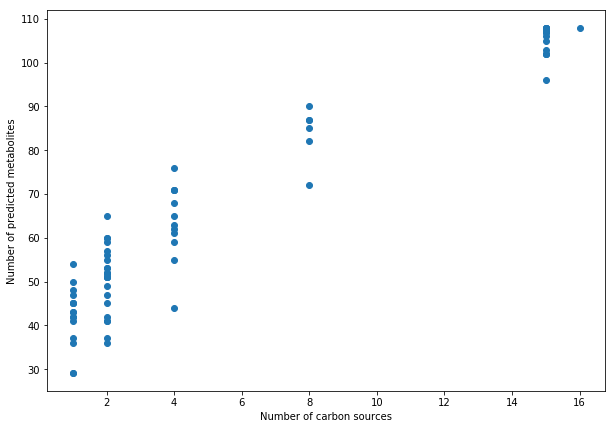

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,7))
plt.scatter( list( map( len, kegg_media ) ), list( filt_scope_size.values() ) )
plt.xlabel( 'Number of carbon sources' )
plt.ylabel( 'Number of predicted metabolites' )

# Saving metabolite matrix

### Calculating which metabolites were produced across all media (we will only save those).

There are only ~100 out of 1000s of metabolites, and we are only interested in saving those that were at least produced once.

In [31]:
cpds_scope = np.sort(uniqify(unlistify([ [e for e in np.nonzero( filt_scope[ sn ] )[0]] for sn in range(1, len(kegg_media) + 1) ])))

smap = {cpds_scope[e] : e+1 for e in range(len(cpds_scope))}
smap_inv = {value: key for key, value in smap.items()}

There are 108 metabolites, in fact.

In [32]:
len(smap)

108

### Merging custom KEGG metabolites

Some KEGG metabolites, such as alpha and beta D glucose, are treated as separate metabolites by KEGG, but we want to merge them into one metabolite, so as not to double count them. The file merge_dict contains a manually curated mapping of which metabolites need to be merged into which others.

In [33]:
mdf = pd.read_csv( 'merge_dict.txt', sep='\t', header=None )
mdict = dict( mdf.values )
mdict

{35: 4, 43: 4, 64: 13, 77: 56, 83: 19, 96: 10, 97: 51}

First, we merge the metabolites and make sure if one of them is present in the scope, then it is counted. We do this by setting the first metabolite in the mapping to be present (equal to 1 in the scope).

In [34]:
for mkey in mdict:
    for media_id in range( len( filt_scope ) ):
        if filt_scope[ media_id + 1 ][ smap_inv[ mkey ] ] == 1 and filt_scope[ media_id + 1 ][ smap_inv[ mdict[ mkey ] ] ] == 0:
            filt_scope[ media_id + 1 ][ smap_inv[ mdict[ mkey ] ] ] = 1

### Remove merged metabolites from the matrix and dicts

Here, we are removing the second metabolite in the mapping from all scopes. This is to prevent double counting.

In [38]:
pres_mets = { i+1 :np.nonzero(filt_scope[i+1])[0] for i in range(len(kegg_media))}

to_filt_out = [ smap_inv[ e ] for e in mdict ] 

filt_pres_mets = {}
for media_id in range( 1, len( filt_scope ) + 1 ):
    filt_pres_mets[ media_id ] = np.asarray( [ e for e in pres_mets[ media_id ] if e not in to_filt_out ] )

### Saving the final matrix after filtering

The shape of the matrix is the number of media (75) by the number of metabolites (108). The first row and column are deliberately left blank.

In [39]:
metm = np.zeros((len(kegg_media)+1, len(smap)+1))
for i in range(len(kegg_media)):
    to_pos = list(filt_pres_mets[i+1])
    for t in to_pos:
        metm[i+1][smap[t]] = 1
    if not (np.array([smap_inv[e] for e in np.where(metm[i+1])[0]]) == filt_pres_mets[i+1]).all():
        print('ERROR')
    
np.savetxt("metabolic_matrix.csv", metm, delimiter=",")

### Creating a mapping between metabolite number and name for human readability

In [40]:
scope_map_dict = {e+1:cpd_string_dict[id_to_kegg[smap_inv[e+1]]] for e in range(len(smap_inv))}

In [41]:
import csv

with open('scope_map_table.csv', 'w') as f:
    w = csv.DictWriter(f, scope_map_dict.keys())
    w.writeheader()
    w.writerow(scope_map_dict)

IndentationError: unexpected indent (<ipython-input-41-746c6aa18bcb>, line 4)